<a href="https://colab.research.google.com/github/ljrn8/quick-notebooks/blob/main/ML_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMP3010 Machine Learning Assignment | 20757218 Joel Hoefs
Markdown cells are organised based on the criteria given in the assingment description for clarities sake.

## Setup

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sklearn

files = os.listdir('.')
assert files
for f in os.listdir('.'):
  print(f)

.config
test.csv
train.csv
sample_prediction.csv
sample_data


In [86]:
sample_pred = pd.read_csv('sample_prediction.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
list(train.columns)

['Unnamed: 0',
 'Tank Failure Pressure (bar)',
 'Liquid Ratio',
 'Tank Width (m)',
 'Tank Length (m)',
 'Tank Height (m)',
 'BLEVE Height (m)',
 'Vapour Height (m)',
 'Vapour Temperature (K)',
 'Liquid Temperature (K)',
 'Obstacle Distance to BLEVE (m)',
 'Obstacle Width (m)',
 'Obstacle Height (m)',
 'Obstacle Thickness (m)',
 'Obstacle Angle',
 'Status',
 'Liquid Critical Pressure (bar)',
 'Liquid Boiling Temperature (K)',
 'Liquid Critical Temperature (K)',
 'Sensor ID',
 'Sensor Position Side',
 'Sensor Position x',
 'Sensor Position y',
 'Sensor Position z',
 'Target Pressure (bar)']

## Preprocessing


#### Identifying and Handling Missing Values
"Examine the dataset for missing or
incomplete entries. Choose appropriate strategies such as imputation or deletion, depending on the context and potential impact on model performance."

In [70]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10050 entries, 0 to 10049
Data columns (total 25 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       10043 non-null  float64
 1   Tank Failure Pressure (bar)      10040 non-null  float64
 2   Liquid Ratio                     10041 non-null  float64
 3   Tank Width (m)                   10043 non-null  float64
 4   Tank Length (m)                  10045 non-null  float64
 5   Tank Height (m)                  10042 non-null  float64
 6   BLEVE Height (m)                 10040 non-null  float64
 7   Vapour Height (m)                10041 non-null  float64
 8   Vapour Temperature (K)           10022 non-null  float64
 9   Liquid Temperature (K)           10022 non-null  float64
 10  Obstacle Distance to BLEVE (m)   10042 non-null  float64
 11  Obstacle Width (m)               10042 non-null  float64
 12  Obstacle Height (m

In [71]:
# The amount of columns with null entries is insignificant -> deletion is appropriate.
train_processed = train.dropna()
print(f'n rows dropped: {len(train) - len(train_processed)}')

n rows dropped: 110


#### Outlier Detection and Treatment
"Detect and address any outliers that may distort your analysis. Apply suitable statistical techniques to correct or exclude these
anomalies."



In [72]:
from scipy import stats

# filter outliers with the Z score method (z=3)
z = stats.zscore(train_processed.drop('Status', axis=1))
non_outliers = abs(z) < 3
non_outliers_mask = non_outliers.all(axis=1)

outliers = len(train_processed) - len(train_processed[non_outliers_mask])
rate = outliers / len(train_processed)
print(f'num outliers: {outliers}\noutlier rate: {rate*100} %')

num outliers: 290
outlier rate: 2.9175050301810868 %


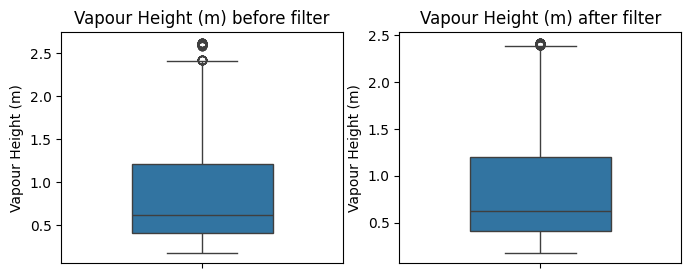

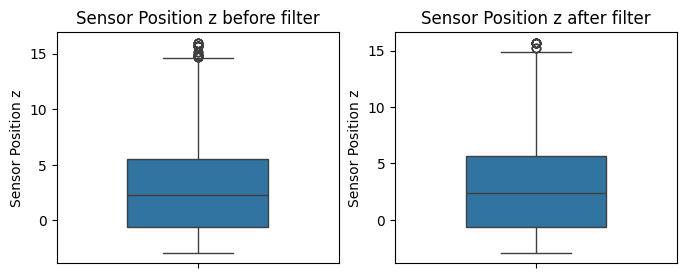

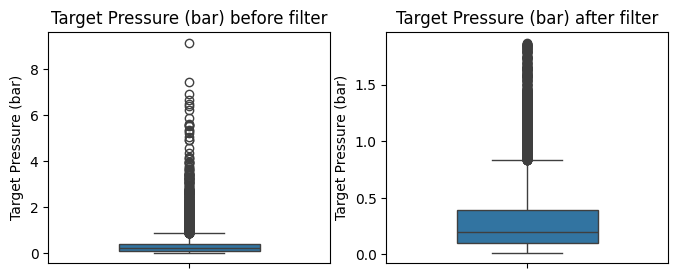

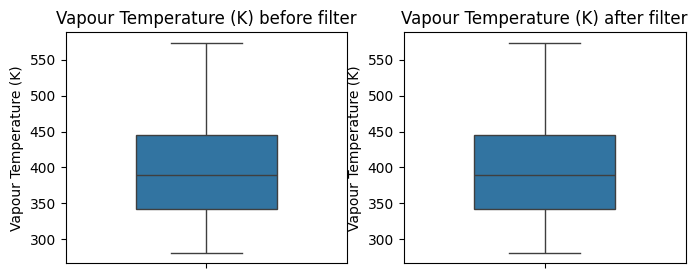

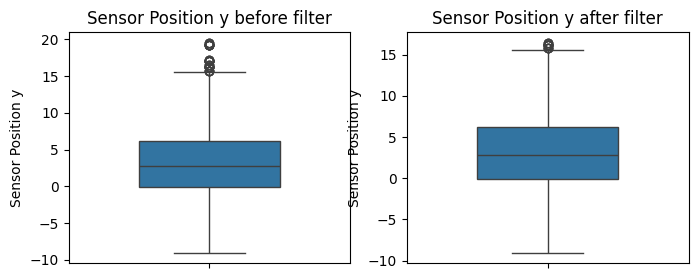

In [73]:
import seaborn as sns

outliers = abs(z) > 2
columns = train_processed.drop('Status', axis=1).columns
cols_ranked_by_outliers = sorted(columns, key=lambda c: -outliers[c].sum())

# Get a quick idea of the number of outliers ommitted for the columns with most outliers
for c in cols_ranked_by_outliers[:5]:

    plt.figure(figsize=(8, 3))
    ax = plt.subplot(1, 2, 1)
    sns.boxplot(data=train_processed[c], width=0.5, ax=ax)
    ax.set_title(c + ' before filter')

    ax = plt.subplot(1, 2, 2)
    sns.boxplot(data=train_processed[non_outliers_mask][c], width=0.5, ax=ax)
    ax.set_title(c + ' after filter')

    plt.show()

In [74]:
train_processed = train_processed[non_outliers_mask]

#### Duplicate Removal
"Ensure dataset integrity by identifying and removing duplicate
records, which can otherwise bias the model."

In [50]:
train_drop_duplicates = train_processed.drop_duplicates()
len(train_drop_duplicates), len(train_processed)

(8264, 8264)

no duplicates found

#### Correcting Inaccurate Entries
"Carefully inspect the data for incorrect values and
rectify them to maintain dataset quality."


In [79]:
train_processed.columns

Index(['Unnamed: 0', 'Tank Failure Pressure (bar)', 'Liquid Ratio',
       'Tank Width (m)', 'Tank Length (m)', 'Tank Height (m)',
       'BLEVE Height (m)', 'Vapour Height (m)', 'Vapour Temperature (K)',
       'Liquid Temperature (K)', 'Obstacle Distance to BLEVE (m)',
       'Obstacle Width (m)', 'Obstacle Height (m)', 'Obstacle Thickness (m)',
       'Obstacle Angle', 'Status', 'Liquid Critical Pressure (bar)',
       'Liquid Boiling Temperature (K)', 'Liquid Critical Temperature (K)',
       'Sensor ID', 'Sensor Position Side', 'Sensor Position x',
       'Sensor Position y', 'Sensor Position z', 'Target Pressure (bar)'],
      dtype='object')

In [122]:
def filter_range(df, c, ub, lb):
  df_filtered = df[(df[c] >= lb) & (df[c] <= ub)]
  n_filtered =  len(df) - len(df_filtered)
  print(f'number of out-of-bounds [{c}] instances = {n_filtered}')
  return df_filtered

# rational metric upperbound for Kelvin/metres
UB = 1_000

filter_range_map = {
  'Tank Failure Pressure (bar)': (0, np.inf),
  'Liquid Ratio': (0, 1),
  'Tank Width (m)': (0, UB),
  'Tank Length (m)': (0, UB),
  'Tank Height (m)': (0, UB),
  'Vapour Height (m)': (0, UB),
  'BLEVE Height (m)': (0, UB),
  'Vapour Temperature (K)': (0, np.inf),
  'Liquid Temperature (K)': (0, UB),
  'Obstacle Distance to BLEVE (m)': (0, UB),
  'Obstacle Width (m)': (0, UB),
  'Obstacle Height (m)': (0, UB),
  'Obstacle Thickness (m)': (0, UB),
  'Obstacle Angle': (0, 30),
  'Sensor ID': (1, 27),
  'Sensor Position Side': (1, 5),
  'Sensor Position x': (-UB, UB),
  'Sensor Position y': (-UB, UB),
  'Sensor Position z': (-UB, UB),
  'Target Pressure (bar)': (0, np.inf),
}

train_interm = train_processed.copy()
for column, (lb, ub) in filter_range_map.items():
  train_interm = filter_range(train_interm, column, ub, lb)


number of out-of-bounds [Tank Failure Pressure (bar)] instances = 0
number of out-of-bounds [Liquid Ratio] instances = 0
number of out-of-bounds [Tank Width (m)] instances = 0
number of out-of-bounds [Tank Length (m)] instances = 0
number of out-of-bounds [Tank Height (m)] instances = 0
number of out-of-bounds [Vapour Height (m)] instances = 0
number of out-of-bounds [BLEVE Height (m)] instances = 0
number of out-of-bounds [Vapour Temperature (K)] instances = 0
number of out-of-bounds [Liquid Temperature (K)] instances = 0
number of out-of-bounds [Obstacle Distance to BLEVE (m)] instances = 0
number of out-of-bounds [Obstacle Width (m)] instances = 0
number of out-of-bounds [Obstacle Height (m)] instances = 0
number of out-of-bounds [Obstacle Thickness (m)] instances = 0
number of out-of-bounds [Obstacle Angle] instances = 0
number of out-of-bounds [Sensor ID] instances = 0
number of out-of-bounds [Sensor Position Side] instances = 0
number of out-of-bounds [Sensor Position x] instance

All columns adhered to the required range, except 'BLEVE Height (m)'

(-0.1, 0.1)

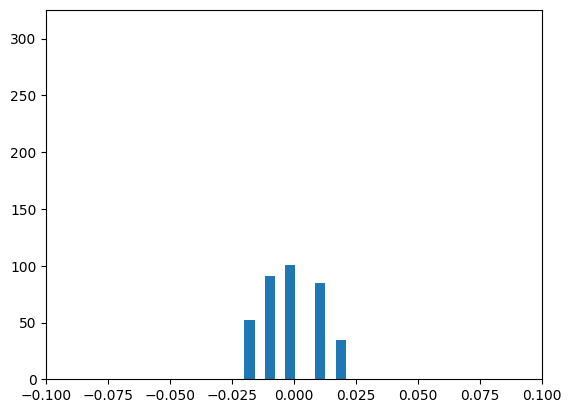

In [116]:
plt.hist(train_processed['BLEVE Height (m)'], bins=500)
plt.xlim(-0.1, 0.1)

some BlEVE Height measurements where negative, and given their proximity to 0, I will simply round up.

In [120]:
train_processed['BLEVE Height (m)'] = train_processed['BLEVE Height (m)'].map(lambda x: max(x, 0))

In [126]:
# ensure no incorrect categorical/ordinal entries:
for c in ('Status', 'Sensor Position Side', 'Sensor ID'):
  print(c + ' unique values: ')
  print(np.unique(train_processed[c]))
  print()

Status unique values: 
['subcooled' 'superheated']

Sensor Position Side unique values: 
[1. 2. 3. 4. 5.]

Sensor ID unique values: 
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27.]



'Status' entries should be either 'subcooled' or 'superheated'

In [125]:
def status_map(name):
  if name in ['Saperheated', 'Superheat', 'Superheated', 'superheated']:
    return 'superheated'
  else:
    return 'subcooled'

train_processed['Status'] = train_processed['Status'].map(status_map)
np.unique(train_processed['Status'])

array(['subcooled', 'superheated'], dtype=object)

#### Feature Selection
"Identify and retain only the features that exhibit meaningful correlation with the target variable. Consider building a “sparse” model using a reduced
set of the most informative features"

#### Feature Engineering
"You are encouraged to derive new features that could improve
model performance. For instance, the ratio Tank Width
Tank Length may serve as a useful additional
feature."

#### Data Type Conversion
"Convert features to appropriate data types as required by
your model. For example, categorical variables may need to be encoded into numerical
formats using one-hot encoding or similar techniques"

#### Feature Scaling
"Apply normalization or standardization where appropriate, particularly for models sensitive to input magnitudes."

#### Data Augmentation:
"To improve model robustness, consider techniques for increasing the number of training samples, such as synthetic data generation."


#### Other Preprocessing Steps
"You may apply any other preprocessing methods that
you find beneficial."


## Model Developement

In [ ]:
from sklearn.model_selection import train_test_split

X, y = train.drop('Target Pressure (bar)', axis=1), train['Target Pressure (bar)']

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42)

for d in X_train, X_valid, y_train, y_valid:
  print(len(d), end='\t')

8040	2010	8040	2010	

#### Model Selection

#### Hyperparameter Tuning

#### Evaluation Metrics:

#### Model Ensembling (Optional)